In [1]:
# inference.py
# %%
import torch
import os
import nrrd
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, AsDiscrete
from monai.networks.nets import UNet

In [2]:
# Define the paths
model_path = "logs/VanillaUNet3D/Unet3D_1500EP_7Subjects_32patch_David.pth"
input_dir = "./data/Inference"  # Directory containing the input NRRD images
output_dir = "./data/Results"    # Directory to save the results


In [3]:
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Load the model
from monai.networks.layers import Norm
device = torch.device('cpu')
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


In [5]:
# Load the trained model weights
model.load_state_dict(torch.load(model_path))
model.eval()


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [6]:
inference_transforms = Compose(
    [
        LoadImaged(keys=["image"], reader="NrrdReader", image_only=True),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
    ]
)


In [35]:
from collections import OrderedDict
import numpy as np

metadata = OrderedDict([
    ('type', 'int'),
    ('dimension', 3),
    ('space', 'left-posterior-superior'),
    ('sizes', np.array([256, 256,  64])),
    ('space directions',
     np.array([[ 0.    ,  0.9375,  0.    ],
               [ 0.    ,  0.    , -0.9375],
               [-2.    ,  0.    ,  0.    ]])),
    ('kinds', ['domain', 'domain', 'domain']),
    ('endian', 'little'),
    ('encoding', 'gzip'),
    ('space origin',
    np.array([  65.92974854, -153.45797729,  147.62498474])),
    ('Segment0_Color', '0.501961 0.682353 0.501961'),
    ('Segment0_ColorAutoGenerated', '1'),
    ('Segment0_Extent', '0 255 0 255 0 63'),
    ('Segment0_ID', 'Segment_1'),
    ('Segment0_LabelValue', '1'),
    ('Segment0_Layer', '0'),
    ('Segment0_Name', 'Segment_1'),
    ('Segment0_NameAutoGenerated', '1'),
    ('Segment0_Tags',
     'Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^85756007^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|'),
    ('Segmentation_ContainedRepresentationNames',
     'Binary labelmap|Closed surface|'),
    ('Segmentation_ConversionParameters',
     'Decimation factor|0.0|Desired reduction in the total number of polygons. Range: 0.0 (no decimation) to 1.0 (as much simplification as possible). Value of 0.8 typically reduces data set size by 80% without losing too much details.&Smoothing factor|0.5|Smoothing factor. Range: 0.0 (no smoothing) to 1.0 (strong smoothing).&Compute surface normals|1|Compute surface normals. 1 (default) = surface normals are computed. 0 = surface normals are not computed (slightly faster but produces less smooth surface display, not used if vtkSurfaceNets3D is used).&Conversion method|0|Conversion method. 0 (default) = vtkDiscreteFlyingEdges3D is used to generate closed surface. 1 = vtkSurfaceNets3D (more performant than flying edges).&SurfaceNets smoothing|0|SurfaceNets smoothing. 0 (default) = Smoothing done by vtkWindowedSincPolyDataFilter1 = Smoothing done in surface nets filter.&Joint smoothing|0|Perform joint smoothing.&Reference image geometry|0;0;2;-63.00000000000001;-0.9375;0;0;142.1784362793;0;-0.9375;0;154.5099029541;0;0;0;1;0;255;0;255;0;63;|Image geometry description string determining the geometry of the labelmap that is created in course of conversion. Can be copied from a volume, using the button.&Oversampling factor|1|Determines the oversampling of the reference image geometry. If it\'s a number, then all segments are oversampled with the same value (value of 1 means no oversampling). If it has the value "A", then automatic oversampling is calculated.&Crop to reference image geometry|0|Crop the model to the extent of reference geometry. 0 (default) = created labelmap will contain the entire model. 1 = created labelmap extent will be within reference image extent.&Collapse labelmaps|1|Merge the labelmaps into as few shared labelmaps as possible 1 = created labelmaps will be shared if possible without overwriting each other.&Fractional labelmap oversampling factor|1|Determines the oversampling of the reference image geometry. All segments are oversampled with the same value (value of 1 means no oversampling).&Threshold fraction|0.5|Determines the threshold that the closed surface is created at as a fractional value between 0 and 1.&'),
    ('Segmentation_MasterRepresentation', 'Binary labelmap'),
    ('Segmentation_ReferenceImageExtentOffset', '0 0 0')
])

In [36]:
# Perform inference
for filename in os.listdir(input_dir):
    if filename.endswith(".nrrd"):
        input_path = os.path.join(input_dir, filename)
        data_dict = {"image": input_path}
        
        # Apply transforms
        transformed = inference_transforms(data_dict)
        input_tensor = transformed["image"].unsqueeze(0).to(device)  # Adding batch dimension
        
        with torch.no_grad():
            output = model(input_tensor)
            output_probs = torch.softmax(output, dim=1)
            output_segmentation = torch.argmax(output_probs, dim=1).cpu().numpy()  # Get predicted segmentation
        
        # Save the segmentation result
        output_filename = os.path.join(output_dir, filename)
        nrrd.write(output_filename.replace('.nrrd', '.seg.nrrd'), np.squeeze(output_segmentation), metadata)

        print(f"Processed {filename}, saved segmentation as {output_filename.replace('.nrrd', '.seg.nrrd')}")


Processed o_NO.nrrd, saved segmentation as ./data/Results/o_NO.seg.nrrd
Processed 6 3DGRE_A FATHER 3D.nrrd, saved segmentation as ./data/Results/6 3DGRE_A FATHER 3D.seg.nrrd
Processed full_area.seg.nrrd, saved segmentation as ./data/Results/full_area.seg.seg.nrrd
Processed E_HEAD.nrrd, saved segmentation as ./data/Results/E_HEAD.seg.nrrd
Processed u_FOOD.nrrd, saved segmentation as ./data/Results/u_FOOD.seg.nrrd
Processed ae_HAT.nrrd, saved segmentation as ./data/Results/ae_HAT.seg.nrrd
Processed A_FATHER.nrrd, saved segmentation as ./data/Results/A_FATHER.seg.nrrd
Processed I_FEET.nrrd, saved segmentation as ./data/Results/I_FEET.seg.nrrd


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd

# Example usage:
file_path = 'data/Results/A_FATHER.seg.nrrd'
data, metadata = nrrd.read(file_path)

In [30]:
data.shape, metadata

((256, 256, 64),
 OrderedDict([('type', 'int64'),
              ('dimension', 3),
              ('sizes', array([256, 256,  64])),
              ('endian', 'little'),
              ('encoding', 'gzip')]))

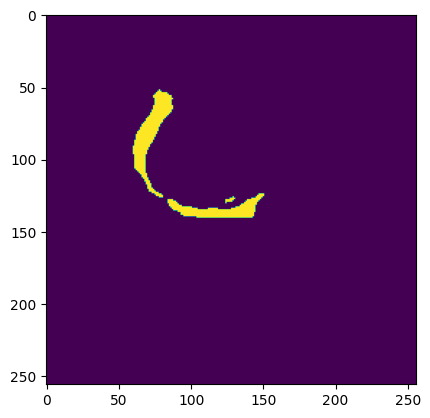

In [31]:
plt.imshow(np.squeeze(data)[:,:,35])

In [32]:
file_path2 = 'data/Inference/A_FATHER.nrrd'
data2, metadata = nrrd.read(file_path2)
data2.shape, metadata

((256, 256, 64),
 OrderedDict([('type', 'short'),
              ('dimension', 3),
              ('space', 'left-posterior-superior'),
              ('sizes', array([256, 256,  64])),
              ('space directions',
               array([[ 0.    ,  0.9375,  0.    ],
                      [ 0.    ,  0.    , -0.9375],
                      [-2.    ,  0.    ,  0.    ]])),
              ('kinds', ['domain', 'domain', 'domain']),
              ('endian', 'little'),
              ('encoding', 'gzip'),
              ('space origin',
               array([  65.92974854, -153.45797729,  147.62498474]))]))

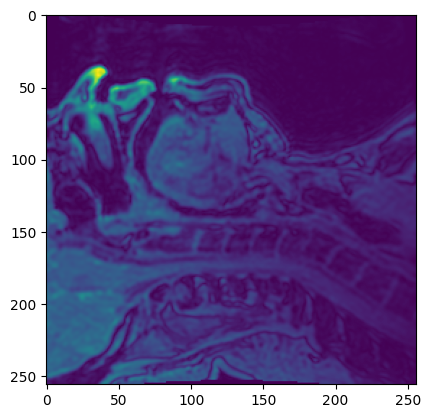

In [33]:
plt.imshow(np.squeeze(data2)[:,:,35])

In [34]:
from collections import OrderedDict
import numpy as np

metadata = OrderedDict([
    ('type', 'int'),
    ('dimension', 3),
    ('space', 'left-posterior-superior'),
    ('sizes', np.array([256, 256,  64])),
    ('space directions',
     np.array([[ 0.    ,  0.9375,  0.    ],
               [ 0.    ,  0.    , -0.9375],
               [-2.    ,  0.    ,  0.    ]])),
    ('kinds', ['domain', 'domain', 'domain']),
    ('endian', 'little'),
    ('encoding', 'gzip'),
    ('space origin',
    np.array([  65.92974854, -153.45797729,  147.62498474])),
    ('Segment0_Color', '0.501961 0.682353 0.501961'),
    ('Segment0_ColorAutoGenerated', '1'),
    ('Segment0_Extent', '0 255 0 255 0 63'),
    ('Segment0_ID', 'Segment_1'),
    ('Segment0_LabelValue', '1'),
    ('Segment0_Layer', '0'),
    ('Segment0_Name', 'Segment_1'),
    ('Segment0_NameAutoGenerated', '1'),
    ('Segment0_Tags',
     'Segmentation.Status:inprogress|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^85756007^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|'),
    ('Segmentation_ContainedRepresentationNames',
     'Binary labelmap|Closed surface|'),
    ('Segmentation_ConversionParameters',
     'Decimation factor|0.0|Desired reduction in the total number of polygons. Range: 0.0 (no decimation) to 1.0 (as much simplification as possible). Value of 0.8 typically reduces data set size by 80% without losing too much details.&Smoothing factor|0.5|Smoothing factor. Range: 0.0 (no smoothing) to 1.0 (strong smoothing).&Compute surface normals|1|Compute surface normals. 1 (default) = surface normals are computed. 0 = surface normals are not computed (slightly faster but produces less smooth surface display, not used if vtkSurfaceNets3D is used).&Conversion method|0|Conversion method. 0 (default) = vtkDiscreteFlyingEdges3D is used to generate closed surface. 1 = vtkSurfaceNets3D (more performant than flying edges).&SurfaceNets smoothing|0|SurfaceNets smoothing. 0 (default) = Smoothing done by vtkWindowedSincPolyDataFilter1 = Smoothing done in surface nets filter.&Joint smoothing|0|Perform joint smoothing.&Reference image geometry|0;0;2;-63.00000000000001;-0.9375;0;0;142.1784362793;0;-0.9375;0;154.5099029541;0;0;0;1;0;255;0;255;0;63;|Image geometry description string determining the geometry of the labelmap that is created in course of conversion. Can be copied from a volume, using the button.&Oversampling factor|1|Determines the oversampling of the reference image geometry. If it\'s a number, then all segments are oversampled with the same value (value of 1 means no oversampling). If it has the value "A", then automatic oversampling is calculated.&Crop to reference image geometry|0|Crop the model to the extent of reference geometry. 0 (default) = created labelmap will contain the entire model. 1 = created labelmap extent will be within reference image extent.&Collapse labelmaps|1|Merge the labelmaps into as few shared labelmaps as possible 1 = created labelmaps will be shared if possible without overwriting each other.&Fractional labelmap oversampling factor|1|Determines the oversampling of the reference image geometry. All segments are oversampled with the same value (value of 1 means no oversampling).&Threshold fraction|0.5|Determines the threshold that the closed surface is created at as a fractional value between 0 and 1.&'),
    ('Segmentation_MasterRepresentation', 'Binary labelmap'),
    ('Segmentation_ReferenceImageExtentOffset', '0 0 0')
])
nrrd.write(file_path, np.squeeze(data), metadata)